<a href="https://colab.research.google.com/github/bobby-mclaughlinjr/covid/blob/master/seir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings; warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
from copy import deepcopy
import datetime
from functools import wraps, partial
!pip install lmfit
from lmfit import Model
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider, FloatSlider, fixed, VBox, HBox, Label, Output, Button, Dropdown, Layout

### SEIR Model
Borrowed from: https://gabgoh.github.io/COVID/index.html

In [0]:
# Default parameters
POPULATION = 7e6
INITIAL_INFFECTIONS = 1
R_NAUGHT = 2.2
INCUBATION_DURATION = 5.2
INFECTION_DURATION = 2.9
CASE_FATALITY_RATE = 2/100
INCUBATION_TO_DEATH_DAYS = 32
HOSPITALIZATION_RATE = 2/10
HOSPITAL_LAG = 5
RECOVERY_SEVERE = 31.5
RECOVERY_MILD = 14
INTERVENTION_TIME = 100
TRANSMISSION_REDUCTION = 2/3

INTEGRATORS = {
                'Euler': [[1]],
                'Midpoint': [[.5, .5], [0, 1]],
                'Heun': [[1, 1], [.5, .5]],
                'Ralston': [[2 / 3, 2 / 3], [.25, .75]],
                'K3': [[.5, .5], [1, -1, 2], [1 / 6, 2 / 3, 1 / 6]],
                'SSP33': [[1, 1], [.5, .25, .25], [1 / 6, 1 / 6, 2 / 3]],
                'SSP43': [[.5, .5], [1, .5, .5], [.5, 1 / 6, 1 / 6, 1 / 6], [1 / 6, 1 / 6, 1 / 6, 1 / 2]],
                'RK4': [[.5, .5], [.5, 0, .5], [1, 0, 0, 1], [1 / 6, 1 / 3, 1 / 3, 1 / 6]],
                'RK38': [[1 / 3, 1 / 3], [2 / 3, -1 / 3, 1], [1, 1, -1, 1], [1 / 8, 3 / 8, 3 / 8, 1 / 8]]
                }

INTERPOLATION_STEPS = 40
SEIR_MAP_KEYS = ['susceptible', 'exposed', 'infectious', 'mild', 'severe_at_home', 'severe_at_hospital', 'fatal', 'recovered_mild', 'recovered_severe', 'recovered_fatal']


class SEIR(object):

    """
        The clinical dynamics in this model are an elaboration on SEIR that simulates the disease's progression at a
        higher resolution, subdividing I,RI,R into mild (patients who recover without the need for hospitalization),
        moderate (patients who require hospitalization but survive) and fatal (patients who require hospitalization
        and do not survive). Each of these variables follows its own trajectory to the final outcome, and the sum of
        these compartments add up to the values predicted by SEIR.

        Please refer to the source code for details. Note that we assume, for simplicity, that all fatalities come
        from hospitals, and that all fatal cases are admitted to hospitals immediately after the infectious period.
    """

    def __init__(self, population=POPULATION, initial_infections=INITIAL_INFFECTIONS, R0=R_NAUGHT
                     , incubation_duration=INCUBATION_DURATION, infection_duration=INFECTION_DURATION, case_fatality_rate=CASE_FATALITY_RATE
                     , incubation_to_death_days=INCUBATION_TO_DEATH_DAYS, hospitalization_rate=HOSPITALIZATION_RATE, hospital_lag=HOSPITAL_LAG
                     , recovery_severe=RECOVERY_SEVERE, recovery_mild=RECOVERY_MILD, intervention_time=INTERVENTION_TIME
                     , transmission_reduction=TRANSMISSION_REDUCTION, duration=7 * 12 * 1e10, time_step=2
                     ):

        self.population = population
        self.initial_infections = initial_infections
        self.R0 = R0
        self.incubation_duration = incubation_duration
        self.infection_duration = infection_duration

        self.case_fatality_rate = case_fatality_rate
        self.incubation_to_death_days = incubation_to_death_days
        self.recovery_severe = recovery_severe - infection_duration
        self.recovery_mild = recovery_mild - infection_duration
        self.hospitalization_rate = hospitalization_rate
        self.hospital_lag = hospital_lag
        self.intervention_time = intervention_time
        self.transmission_reduction = transmission_reduction
        
        self.duration = duration
        self.time_step = time_step

        self.results = None
        self.summary = None

        self.output = Output()
        self.interact = None

        sliders = {'population': IntSlider(min=100, max=9e9, step=10000, value=population, description='Size of population')
                   , 'initial_infections': IntSlider(min=1, max=10000, step=25, value=initial_infections, description='Number of initial infections')
                   , 'R0': FloatSlider(min=0.01, max=10, step=0.02, value=R0, description='Basic reproduction number')
                   , 'incubation_duration': FloatSlider(min=0.1, max=24, step=0.1, value=incubation_duration, description='Length of incubation period, Tinc', readout_format='.1f')
                   , 'infection_duration': FloatSlider(min=0, max=24, step=0.1, value=infection_duration, description='Duration patient is infectious, Tinf', readout_format='.1f')
                   , 'case_fatality_rate': FloatSlider(min=0, max=1, step=0.005, value=case_fatality_rate, description='Case fatality rate', readout_format='.2%')
                   , 'incubation_to_death_days': FloatSlider(min=3, max=100, step=1, value=incubation_to_death_days, description='Time from end of incubation to death', readout_format='.0f')
                   , 'recovery_severe': FloatSlider(min=0.1, max=100, step=0.1, value=self.recovery_severe, description='Length of hospital stay', readout_format='.1f')
                   , 'recovery_mild': FloatSlider(min=0.1, max=100, step=0.1, value=self.recovery_mild, description='Recovery time for mild cases', readout_format='.1f')
                   , 'hospitalization_rate': FloatSlider(min=0, max=1, step=0.02, value=hospitalization_rate, description='Hospitalization rate', readout_format='.0%')
                   , 'hospital_lag': FloatSlider(min=0.5, max=100, step=0.5, value=hospital_lag, description='Time to hospitalization', readout_format='.1f')
                   , 'intervention_time': IntSlider(min=0, max=199, step=1, value=intervention_time, description='Day of intervention')
                   , 'transmission_reduction': FloatSlider(min=0, max=1, step=0.01, value=transmission_reduction, description='Transmission reduction', readout_format='.0%')
                  }

        self.create_sliders(sliders)

    @property
    def time_to_death_post_infection(self):
        return self.incubation_to_death_days - self.infection_duration

    @property
    def intervention_amount(self):
        return 1 - self.transmission_reduction

    @property
    def alpha(self):
        return 1 / self.incubation_duration

    @property
    def gamma(self):
        return 1 / self.infection_duration

    @staticmethod
    def steps():
        return 100 * INTERPOLATION_STEPS

    def create_sliders(self, sliders):
        results = []
        for name, slider in sliders.items():
            slider_name = name + '_slider'
            slider.continuous_update = False
            description = slider.description
            slider.description = ' '
            
            setattr(self, slider_name, interactive(self.set_and_get_solution, value=slider, name=fixed(name)))
            results.append(VBox([Label(description), getattr(self, slider_name)], layout=Layout(border='solid')))
        
        boxes = []
        box_intervals = list(range(0, len(results), 3))
        for i in box_intervals:
            if i == box_intervals[-1]:
                boxes.append(HBox(results[i:]))
            else:
                boxes.append(HBox(results[i:i+3]))
        
        self.interact = VBox([self.output, VBox(boxes)])
        return self

    def set_and_get_solution(self, name=None, value=None):
        if name is not None: setattr(self, name, value)

        self.output.clear_output(wait=True)
        with self.output as f:
            self.get_solution().plot()
            peak_day, peak_amount = self.get_milestones('hospitalized')
            print('Peak hospitalizations on day ' + str(peak_day) + ': ' + str(int(peak_amount)))

    def set_attributes(self, **kwargs):
        for key, value in kwargs.items():
            try:
                setattr(self, key, value)
            except:
                pass

        return self

    def create_seir_map(self, values=None):
        if values is None:
            seir_map = {}
            for key in SEIR_MAP_KEYS:
                if key == 'susceptible':
                    value = 1 - self.initial_infections / self.population
                elif key == 'infectious':
                    value = self.initial_infections / self.population
                else:
                    value = 0

                seir_map[key] = value
        else:
            seir_map = {SEIR_MAP_KEYS[i]: value for i, value in enumerate(values)}

        return seir_map

    def beta(self, t):
        if (t > self.intervention_time) & (t < (self.intervention_time + self.duration)):
            beta = self.intervention_amount * self.R0 / self.infection_duration
        else:
            if t > self.intervention_time + self.duration:
                beta = 0.5 * self.R0 / self.infection_duration
            else:
                beta = self.R0 / self.infection_duration

        return beta

    def calc(self, t, seir_map):

        beta = self.beta(t)

        susceptible = seir_map['susceptible']
        exposed = seir_map['exposed']
        infectious = seir_map['infectious']

        return [-beta * susceptible * infectious # susceptible
                   , (beta * infectious * susceptible) - (self.alpha * exposed) # exposed
                   , self.alpha * exposed - self.gamma * infectious # infectious
                   , (1 - self.hospitalization_rate - self.case_fatality_rate) * self.gamma * infectious - (1 / self.recovery_mild) * seir_map['mild'] # mild
                   , (self.hospitalization_rate * self.gamma * infectious) - ((1 / self.hospital_lag) * seir_map['severe_at_home']) # severe at home
                   , ((1 / self.hospital_lag) * seir_map['severe_at_home']) - ((1 / self.recovery_severe) * seir_map['severe_at_hospital']) # severe at hospital
                   , self.case_fatality_rate * self.gamma * infectious - (1 / self.time_to_death_post_infection) * seir_map['fatal'] # fatal
                   , (1 / self.recovery_mild) * seir_map['mild'] # recovered_mild
                   , (1 / self.recovery_severe) * seir_map['severe_at_hospital'] # recovered severe
                   , (1 / self.time_to_death_post_infection) * seir_map['fatal'] # recovered fatal
                   ]

    def integrate(self, method, seir_map_values, t, time_step):
        k = []
        ki = 0
        while ki < len(method):
            _y = deepcopy(seir_map_values)
            dt = method[ki - 1][0] * time_step

            l = 0
            while l < len(_y):
                j = 1
                while j <= ki:
                    _y[l] = _y[l] + time_step * method[ki - 1][j] * k[ki - 1][l]
                    j += 1

                l += 1

            k.append(self.calc(t + dt, seir_map=self.create_seir_map(_y)))
            ki += 1

        r = deepcopy(seir_map_values)
        l = 0

        while l < len(_y):
            j = 0
            while j < len(k):
                r[l] = r[l] + time_step * k[j][l] * method[ki - 1][j]
                j += 1
            l += 1

        return r

    def get_solution(self, method=INTEGRATORS['RK4'], **kwargs):

        self.set_attributes(**kwargs)

        time_step = self.time_step / INTERPOLATION_STEPS
        steps = 110 * INTERPOLATION_STEPS

        seir_map_values = list(self.create_seir_map().values())
        t = 0

        results = {}
        summary = {}
        while steps > 0:
            if (steps + 1) % INTERPOLATION_STEPS == 0:
                seir_map = self.create_seir_map(seir_map_values)

                results[steps] = deepcopy(seir_map)
                summary[steps] = {'deaths': self.population * seir_map['recovered_fatal']
                                  , 'hospitalized': self.population * (seir_map['severe_at_hospital'] + seir_map['fatal'])
                                  , 'recovered': self.population * (seir_map['recovered_mild'] + seir_map['recovered_severe'])
                                  , 'infectious': self.population * seir_map['infectious']
                                  , 'exposed': self.population * seir_map['exposed']
                                  }

            seir_map_values = self.integrate(method=method, seir_map_values=seir_map_values, t=t, time_step=time_step)

            t += time_step
            steps -= 1

        self.results = results
        self.summary = summary

        return self

    def fit(self, X, R0, incubation_duration, transmission_reduction, infection_duration, case_fatality_rate, smooth=None, diff=None):
        self.R0 = R0
        self.incubation_duration = incubation_duration
        self.infection_duration = infection_duration
        self.transmission_reduction = transmission_reduction
        self.case_fatality_rate = case_fatality_rate

        return smooth_diff(self.get_solution().format_summary()['deaths'], window=smooth, diff=diff)[:len(X)]

    def format_summary(self):
        return pd.DataFrame.from_dict(self.summary, orient='index').reset_index(drop=True)

    def get_milestones(self, field):

        X = self.format_summary()

        value = max(X[field])
        index = X[field].tolist().index(value) * self.time_step

        return (index, value)

    def first_death(self):
        return next(x[0] for x in enumerate(self.format_summary()['deaths']) if x[1] > 0.7) * self.time_step

    def plot(self):
        ax = self.format_summary()[['exposed', 'hospitalized', 'deaths']].rename(columns={'exposed': 'Exposed', 'hospitalized': 'Hospitalized', 'deaths': 'Deaths'}).plot(kind='line', colormap='cool')

        every_nth = 20
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            label.set_visible(True)

            if n % every_nth != 0:
                label.set_visible(False)

        ax.yaxis.grid(which='major', linestyle='--')
        
        _ = display(plt.show())
        
        return ax

### Data APIs

In [0]:
SOURCES = ['CSSE', 'NYT']

CSSE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
CSSE_COLUMNS = {'Province/State': 'area', 'Country/Region': 'region', 'Lat': 'latitude', 'Long': 'longitude'}

NYT_URL_PREFIX = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-'

FILTERED_REGIONS = ['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'Sweden', 'South Korea', 'Japan', 'Singapore'
                   , 'Denmark', 'Australia', 'California - US', 'Florida - US', 'Georgia - US', 'Illinois - US', 'Louisiana - US'
                   , 'Massachusetts - US', 'Michigan - US', 'New York - US', 'New Jersey - US', 'Pennsylvania - US', 'Texas - US']

def smooth_diff(X, window=None, diff=None):
    if window is not None:
        X = X.rolling(window=window).mean()[window:]

    if diff is not None:
        X = X.diff(diff)[diff:]

    return X


def reset_drop(func):
    @wraps(func)
    def wrapper(X, **kwargs):
        X.reset_index(level=0, drop=True, inplace=True)
        return func(X, **kwargs)

    return wrapper


class Covid(object):

    """Retrieving & manipulating data (cases, deaths, test, etc) related to Covid-19"""

    def __init__(self, regions=None):
        self.regions = regions
        self.data = None

    @property
    def regions(self):
        return self._regions

    @regions.setter
    def regions(self, value):
        if value is None: value = FILTERED_REGIONS
        if not isinstance(value, list): value = [value]

        self._regions = value

    @property
    def single(self):
        return len(self.regions) == 1

    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, value):
        if self.single & (value is not None):
            value.reset_index(level=0, drop=True, inplace=True)

        self._data = value

    @staticmethod
    def get_CSSE():
        df = pd.read_csv(CSSE_URL).rename(columns=CSSE_COLUMNS)
        data = pd.melt(df, id_vars=CSSE_COLUMNS.values(), var_name='date', value_name='cases')
        data['date'] = [datetime.datetime.strptime(str(date), '%m/%d/%y') for date in data['date']]

        return data.groupby(['region', 'date'])['cases'].sum()

    @staticmethod
    def get_NYT():
        data = pd.read_csv(NYT_URL_PREFIX + 'states.csv').rename(columns={'state': 'region'})
        data['region'] = [region + ' - US' for region in data['region']]
        data['date'] = [datetime.datetime.strptime(str(date), '%Y-%m-%d') for date in data['date']]

        return data.groupby(['region', 'date'])['cases'].sum()

    @staticmethod
    def get_NYC():
        data = pd.read_csv(NYT_URL_PREFIX + 'counties.csv')
        data = data[data['county'] == 'New York City']
        data['region'] = data['county'] + ' - ' + data['state']

        data['date'] = [datetime.datetime.strptime(str(date), '%Y-%m-%d') for date in data['date']]

        return data.groupby(['region', 'date'])['cases'].sum()

    @staticmethod
    @reset_drop
    def smooth_diff(X, window=None, diff=None):
        return smooth_diff(X, window=window, diff=diff)

    @staticmethod
    @reset_drop
    def outbreak_shift(X, n=15):
        min_index = X.sort_index().index[0]
        add_series = pd.Series(np.zeros(n), index=[min_index - datetime.timedelta(x) for x in range(1, n+1)])

        return X.append(add_series).sort_index()

    def get_data(self, outbreak_shift=None, smooth=None, diff=None):
        data = pd.concat([self.get_CSSE(), self.get_NYT(), self.get_NYC()]).loc[self.regions, :].sort_index()

        if outbreak_shift is not None:
            data = data.groupby(level=0).apply(self.outbreak_shift, n=outbreak_shift)

        data = data.groupby(level=0).apply(self.smooth_diff, window=smooth, diff=diff)

        self.data = data
        return self

### Fit SEIR model to regional cases

In [0]:
def fit(region, params, outbreak_shift=None, smooth=None, diff=None, population_map=None, lockdown_calendar=None):
    actual = Covid(regions=region).get_data(outbreak_shift=outbreak_shift, smooth=smooth, diff=diff).data
    population = 8398748  # population = population_map[region]
    intervention_time = 40  # intervention_time = lockdown_calendar[region]

    seir = SEIR(population=population, intervention_time=intervention_time, time_step=1)
    model = Model(seir.fit, smooth=smooth, diff=diff)

    for key, (init, min, max) in params.items():
        model.set_param_hint(key, value=init, min=min, max=max, vary=True)

    return model.fit(actual.values, model.make_params(), method='least_squares', X=np.linspace(0, len(actual) - 1, len(actual), dtype=int))

### Test case: New York City

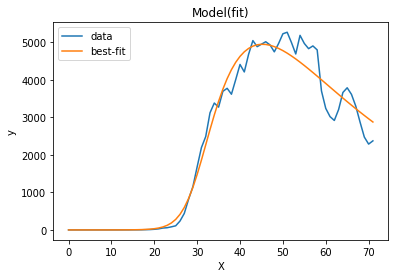

In [7]:
params = {
          'R0': (2.2, 1, 7)
          , 'incubation_duration': (5.2, 2, 10)
          , 'infection_duration': (2.9, 1, 7)
          , 'transmission_reduction': (2/3, 1/10, 9.5/10)
          , 'case_fatality_rate': (2/100, 5/1000, 10/100)
         }

test = SEIR()
result = fit(region='New York City - New York', params=params, outbreak_shift=15, smooth=5, diff=1)
best_values = result.best_values
_ = result.plot_fit(datafmt="-")

In [8]:
obj = SEIR()
obj.interact